# Mask and Social distancing Detection 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from torchvision import transforms,models
import matplotlib.pyplot as plt
from PIL import Image
from random import shuffle
from bs4 import BeautifulSoup
from glob import iglob
from math import ceil
import cv2
import os
import torch

Data Augmentation

In [2]:
transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [3]:
# yolo_face = torch.hub.load('yolov5-face','yolov5s',source = 'local',force_reload=True)
# yolo_face.eval()
# yolo_face.classes = 0
yolo = torch.hub.load('ultralytics/yolov5', 'yolov5s',pretrained = True)
yolo.classes = 0

Using cache found in /Users/yipkwunchuen/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-12-5 Python-3.10.4 torch-1.12.1 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [4]:
def yolo_dict(img_list):
    tensor_list = []
    crop_img_list = []
    # print('len of yolo_pred:',len(yolo_pred))
    for idx,img in enumerate(img_list):
        yolo_pred = yolo(img)
        crop_img = []
        bboxes = yolo_pred.pandas().xyxy[0][['xmin','ymin','xmax','ymax']]
        score = yolo_pred.pandas().xyxy[0]['confidence']
        # print(type(bboxes))
        bbox_list = bboxes.to_numpy()
        score_list =score.to_numpy()
        try:
            bbox_tensor = torch.tensor(bbox_list)
            score_tensor = torch.tensor(score_list)
        except:
            bbox_tensor = torch.zeros([1,4])
            score_tensor = torch.zeros([1])
            print(idx)
        pred_tensor = {'boxes':bbox_tensor,'scores':score_tensor}
        tensor_list.append(pred_tensor)
        
        for bbox in bbox_list:
            crop_img.append(img[ceil(bbox[1]):ceil(bbox[3]),ceil(bbox[0]):ceil(bbox[2])])
        crop_img_list.append(crop_img)
        # print('going to break')
        # break
    return tensor_list,crop_img_list

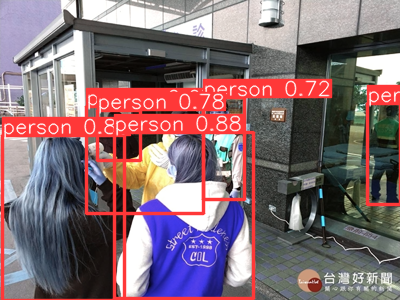

In [6]:
img_paths = ['images/maksssksksss163.png']
img_list = []
for img_path in img_paths:
    img_list.append(cv2.imread(img_path))
tmp1 = yolo(img_list)
tmp1.show()

# yolo_pred = yolo(img_list)
# yolo_pred.pandas().xyxy[0]


### DataSet


In [7]:
#Load train and test set
train_dir = 'FaceMask_12k/Train'
test_dir = 'FaceMask_12k/Test'
val_dir = 'FaceMask_12k/Validation'
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [8]:
class MaskDataset(object):
    def __init__(self, transform,path):
        self.transform = transform
        # load all image files, sorting them to
        # ensure that they are aligned
        # path in forms of 'FaceMask_12k/Test/'
        self.path = path
        
        pos_imgs = []
        pos_imgs_path = list(sorted(os.listdir(path+'/WithMask')))
        for img_path in pos_imgs_path:
            pos_imgs.append(Image.open(path+'/WithMask/'+img_path))
            
        neg_imgs = []
        neg_imgs_path = list(sorted(os.listdir(path+'/WithoutMask')))
        for img_path in neg_imgs_path:
            neg_imgs.append(Image.open(path+'/WithoutMask/'+img_path))
        self.imgs = [*pos_imgs,*neg_imgs]
        
        pos_label = torch.ones(len(pos_imgs),dtype=torch.long)
        neg_label = torch.zeros(len(neg_imgs),dtype=torch.long)
        self.label = [*pos_label,*neg_label]
        
        self.data = list(zip(self.imgs,self.label))
        shuffle(self.data)
        
    def __getitem__(self, idx):
        img, label = self.data[idx]
        if self.transform is not None:
            img = self.transform(img)

        return img, label

    def __len__(self):
        return len(self.imgs)

In [9]:
train_data = MaskDataset(transform,train_dir)
train_data = torch.utils.data.DataLoader(train_data,batch_size = 10)
val_data = MaskDataset(transform,val_dir)
val_data = torch.utils.data.DataLoader(val_data,batch_size = 10)

### Building ResNet 50 transfer learning model.

In [10]:
class ResNet_Trans(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.resnet_50 = models.resnet50(pretrained=True)
        self.extractor = torch.nn.Sequential(*(list(self.resnet_50.children())[:-1]))
        self.sm = torch.nn.Softmax(dim=0)
        self.lr1 = torch.nn.Linear(2048,1024)
        self.lr2 = torch.nn.Linear(1024,2)
    
    def forward(self,x):
        x = self.extractor(x)
        x = x.transpose(1, 3)
        x = self.lr1(x)
#         print(x.shape)
        x = x.squeeze(dim = 1)
        x = x.squeeze(dim = 1)
        x = self.sm(x)
        x = self.lr2(x)
        return x
    
model = ResNet_Trans().to(device)
num_epochs = 5

# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
loss_func = torch.nn.CrossEntropyLoss()

In [11]:
for epoch in range(num_epochs):
    model.train()
    i = 0
    train_epoch_loss = 0
    val_epoch_loss = 0
    running_loss = 0
    for img, annotation in train_data:
        i += 1
        pred = model(img)
        print(pred,annotation)
        loss = loss_func(pred,annotation)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 20 == 0:
            print(
            f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 20:.3f}",
            end="\t",
        )
            running_loss = 0

tensor([[ 0.06768, -0.04874],
        [ 0.06717, -0.04318],
        [ 0.07823, -0.04534],
        [ 0.07337, -0.03968],
        [ 0.07010, -0.03869],
        [ 0.09328, -0.03682],
        [ 0.07031, -0.05944],
        [ 0.06451, -0.05196],
        [ 0.08089, -0.03980],
        [ 0.07805, -0.02547]], grad_fn=<AddmmBackward0>) tensor([0, 1, 0, 0, 0, 1, 1, 0, 1, 1])
tensor([[ 0.07549, -0.03901],
        [ 0.08376, -0.05298],
        [ 0.06768, -0.04770],
        [ 0.07432, -0.04285],
        [ 0.07196, -0.04212],
        [ 0.06509, -0.04000],
        [ 0.07284, -0.04454],
        [ 0.07211, -0.02912],
        [ 0.06059, -0.03248],
        [ 0.08265, -0.04121]], grad_fn=<AddmmBackward0>) tensor([0, 1, 0, 1, 0, 1, 1, 1, 0, 0])
tensor([[ 0.06721, -0.03324],
        [ 0.07621, -0.04127],
        [ 0.08165, -0.04055],
        [ 0.07361, -0.03129],
        [ 0.06496, -0.03666],
        [ 0.06018, -0.03597],
        [ 0.08399, -0.02600],
        [ 0.06364, -0.05189],
        [ 0.06946, -0.04002]

KeyboardInterrupt: 

Load Model State

In [12]:
model.load_state_dict(torch.load('model_weight.pt',map_location='cpu'))
model.eval()

ResNet_Trans(
  (resnet_50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
   

In [25]:
correct_pred = []
wrong_pred = []
count = 0
i=0
for img, annotation in val_data:
    i += 1
    val_pred = model(img)
    label = val_pred.argmax(dim=1)
    # print(torch.eq(label,annotation).tolist())
    a = torch.eq(label,annotation).tolist()
    if False not in torch.eq(label,annotation).tolist():
        correct_pred.append((label,annotation))
    else:
        count += a.count(False)
        wrong_pred.append((label,annotation))

In [12]:
print('Correct Prediction')
for label,annotation in correct_pred:
    print(label,annotation)
print('Wrong Prediction')
for label,annotation in wrong_pred:
    print(label,annotation)

Correct Prediction
tensor([1, 1, 1, 1, 1, 1, 0, 0, 1, 1]) tensor([1, 1, 1, 1, 1, 1, 0, 0, 1, 1])
tensor([1, 0, 1, 1, 0, 0, 1, 0, 0, 1]) tensor([1, 0, 1, 1, 0, 0, 1, 0, 0, 1])
tensor([0, 1, 1, 1, 1, 0, 1, 0, 1, 1]) tensor([0, 1, 1, 1, 1, 0, 1, 0, 1, 1])
tensor([1, 1, 1, 0, 1, 0, 1, 1, 1, 1]) tensor([1, 1, 1, 0, 1, 0, 1, 1, 1, 1])
tensor([0, 0, 1, 1, 0, 0, 1, 0, 1, 1]) tensor([0, 0, 1, 1, 0, 0, 1, 0, 1, 1])
tensor([1, 1, 0, 0, 1, 0, 1, 1, 1, 0]) tensor([1, 1, 0, 0, 1, 0, 1, 1, 1, 0])
tensor([0, 1, 0, 1, 0, 0, 1, 0, 0, 0]) tensor([0, 1, 0, 1, 0, 0, 1, 0, 0, 0])
tensor([0, 0, 0, 1, 0, 0, 1, 1, 1, 0]) tensor([0, 0, 0, 1, 0, 0, 1, 1, 1, 0])
tensor([1, 1, 1, 0, 0, 1, 0, 0, 1, 1]) tensor([1, 1, 1, 0, 0, 1, 0, 0, 1, 1])
tensor([0, 0, 1, 0, 1, 1, 0, 1, 0, 0]) tensor([0, 0, 1, 0, 1, 1, 0, 1, 0, 0])
tensor([1, 1, 1, 0, 1, 1, 1, 0, 0, 1]) tensor([1, 1, 1, 0, 1, 1, 1, 0, 0, 1])
tensor([0, 1, 1, 0, 0, 1, 0, 1, 1, 0]) tensor([0, 1, 1, 0, 0, 1, 0, 1, 1, 0])
tensor([1, 1, 0, 0, 1, 1, 1, 1, 1, 0]) tensor

In [13]:
img_paths = iglob('images/*')
img_list = []
for img_path in sorted(img_paths,key=lambda x: int(x.split(sep='maksssksksss')[1].split(sep='.')[0])):
    img_list.append(cv2.imread(img_path))
print(len(img_list))

# tmp = []
# for face in face_list:
#     face_tensor = transform(Image.fromarray(face,mode="RGB")).unsqueeze(dim=0)
#     face_pred = model(face_tensor)
#     label = face_pred.argmax(dim=1)
#     tmp.extend(label)
# pred_result = torch.tensor(tmp)


libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


853


In [14]:
pred_dict, crop_img_list = yolo_dict(img_list)

63
122
170
226
233
323
446
643
729
830


In [20]:
ignore_list = [63,122,170,226,233,323,446,643,729,830]

In [21]:
# crop image 過 yolo
for idx,crop_list in enumerate(crop_img_list):
    if idx in ignore_list:
        continue
    tmp_list = []
    for img in crop_list:
        a = transform(Image.fromarray(img))
        tmp_list.append(a)
    pred = model(torch.stack(tmp_list))
    label = pred.argmax(dim=1)
    pred_dict[idx]['labels'] = label


In [22]:
def generate_box(obj):
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    return 0

def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([image_id])
        # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        
        return target


In [23]:
class MaskDataset(object):
    def __init__(self, transforms):
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir("images/")))
#         self.labels = list(sorted(os.listdir("/kaggle/input/face-mask-detection/annotations/")))

    def __getitem__(self, idx):
        # load images ad masks
        if idx >= 853:
            return False
        file_label = 'maksssksksss'+ str(idx) + '.xml'
        label_path = os.path.join("annotations/", file_label)
        target = generate_target(idx, label_path)
        return target

    def __len__(self):
        return len(self.imgs)

In [24]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision
mAP = MeanAveragePrecision()
ground_truth = []
for i in range(len(pred_dict)):
    if i in ignore_list:
        continue
    file_label = 'maksssksksss'+ str(idx) + '.xml'
    label_path = os.path.join("annotations/", file_label)
    target = generate_target(idx, label_path)
    ground_truth.append(target)
error_log = []
idx = 0
# mAP.update(pred_dict,ground_truth)
# print(mAP.compute())
print(len(ground_truth))
for annotations in ground_truth:
    pred = pred_dict[idx]
    # print(pred,'\n\n',annotations)
    idx += 1
    try:
        mAP.update([pred],[annotations])
    except Exception as e:
        print(1,end='\t')
        error_log.append((pred,annotation))
        continue


843
1	1	1	1	1	1	1	1	1	1	

In [25]:
mAP.compute()

{'map': tensor(4.69241e-07),
 'map_50': tensor(4.69241e-06),
 'map_75': tensor(0.),
 'map_small': tensor(-1.),
 'map_medium': tensor(3.05586e-06),
 'map_large': tensor(-1.),
 'mar_1': tensor(0.),
 'mar_10': tensor(6.00240e-05),
 'mar_100': tensor(0.00012),
 'mar_small': tensor(-1.),
 'mar_medium': tensor(0.00012),
 'mar_large': tensor(-1.),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.)}